# Audio Watermark Visualization

This notebook visualizes the audio waveform and frequency spectrum to show how the watermark is embedded in the frequency domain.

## Setup
First, let's import our dependencies and load the audio files.


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import rfft, rfftfreq
import os
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
        
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
print("✓ Imports successful!")


✓ Imports successful!


## Load Audio Files
Load both the original and watermarked audio files for comparison.


In [2]:
# File paths
original_path = '../input_data/OSR_us_000_0057_8k.wav'
watermarked_path = '../output_data/OSR_us_000_0057_8k_watermarked.wav'

# Load audio files
sample_rate_orig, audio_orig = wavfile.read(original_path)
sample_rate_wm, audio_wm = wavfile.read(watermarked_path)

# Normalize to [-1, 1]
audio_orig_norm = audio_orig.astype(np.float32) / 32768.0
audio_wm_norm = audio_wm.astype(np.float32) / 32768.0

print(f"Original audio: {len(audio_orig)} samples at {sample_rate_orig} Hz")
print(f"Watermarked audio: {len(audio_wm)} samples at {sample_rate_wm} Hz")
print(f"Duration: {len(audio_orig) / sample_rate_orig:.2f} seconds")


Original audio: 314074 samples at 8000 Hz
Watermarked audio: 314074 samples at 8000 Hz
Duration: 39.26 seconds


## 1. Time-Domain Waveform Comparison
Visualize the raw audio signal in the time domain. The watermark should be nearly invisible in this view.


Plotting from 5.0s to 5.1s
Signal range - Original: [-0.0157, 0.0201]
Signal range - Watermarked: [-0.0159, 0.0201]


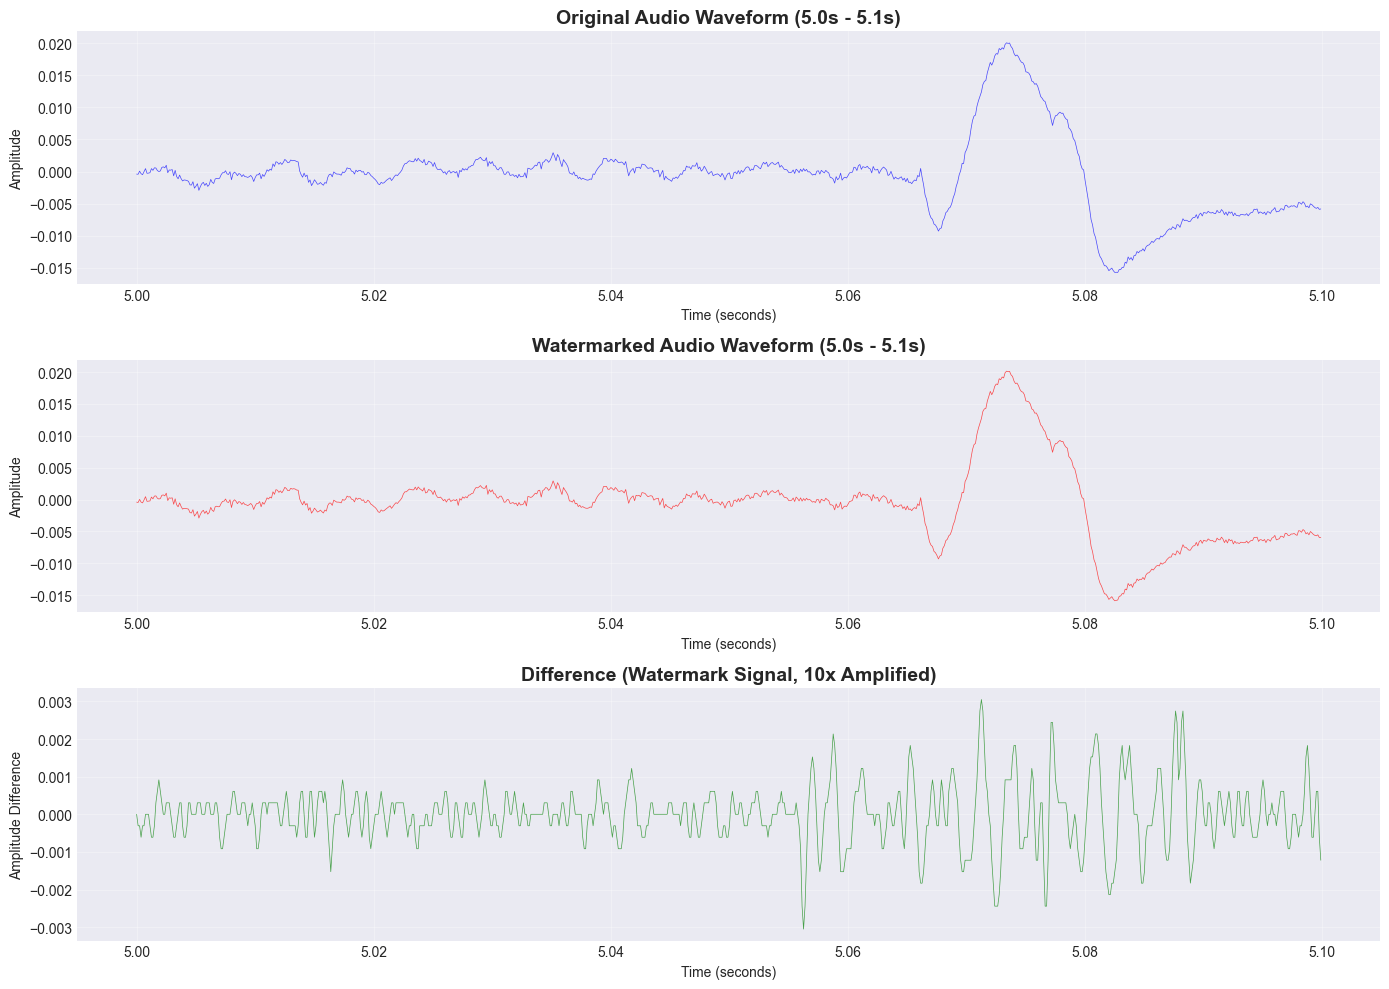


✓ Plots generated successfully!
Max difference: 0.000305
RMS difference: 0.000078


In [3]:
# Create time axis in seconds
time_orig = np.arange(len(audio_orig_norm)) / sample_rate_orig
time_wm = np.arange(len(audio_wm_norm)) / sample_rate_wm

# Find a section with good signal (not silence at start)
# Start from 5 seconds in to avoid silence
duration_to_plot = 0.1  # seconds
start_time = 5.0  # start at 5 seconds
start_sample = int(start_time * sample_rate_orig)
samples_to_plot = int(duration_to_plot * sample_rate_orig)
end_sample = start_sample + samples_to_plot

# Extract the region of interest
time_region = time_orig[start_sample:end_sample]
audio_orig_region = audio_orig_norm[start_sample:end_sample]
audio_wm_region = audio_wm_norm[start_sample:end_sample]

print(f"Plotting from {start_time}s to {start_time + duration_to_plot}s")
print(f"Signal range - Original: [{audio_orig_region.min():.4f}, {audio_orig_region.max():.4f}]")
print(f"Signal range - Watermarked: [{audio_wm_region.min():.4f}, {audio_wm_region.max():.4f}]")

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))

# Original waveform
ax1.plot(time_region, audio_orig_region, 
         linewidth=0.5, color='blue', alpha=0.7)
ax1.set_title(f'Original Audio Waveform ({start_time}s - {start_time + duration_to_plot}s)', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Amplitude')
ax1.grid(True, alpha=0.3)

# Watermarked waveform
ax2.plot(time_region, audio_wm_region, 
         linewidth=0.5, color='red', alpha=0.7)
ax2.set_title(f'Watermarked Audio Waveform ({start_time}s - {start_time + duration_to_plot}s)', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Amplitude')
ax2.grid(True, alpha=0.3)

# Difference (amplified)
difference = audio_wm_region - audio_orig_region
ax3.plot(time_region, difference * 10,  # amplify by 10x for visibility
         linewidth=0.5, color='green', alpha=0.7)
ax3.set_title('Difference (Watermark Signal, 10x Amplified)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Time (seconds)')
ax3.set_ylabel('Amplitude Difference')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Plots generated successfully!")
print(f"Max difference: {np.max(np.abs(difference)):.6f}")
print(f"RMS difference: {np.sqrt(np.mean(difference**2)):.6f}")


## 1.5 Full Audio Waveform Overview
Now let's view the entire audio file to see the overall structure.


In [ ]:
# Plot the entire waveform
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 10))

# Original waveform - full length
ax1.plot(time_orig, audio_orig_norm, linewidth=0.3, color='blue', alpha=0.7)
ax1.set_title('Original Audio Waveform - Full Length', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Amplitude')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, time_orig[-1])

# Watermarked waveform - full length
ax2.plot(time_wm, audio_wm_norm, linewidth=0.3, color='red', alpha=0.7)
ax2.set_title('Watermarked Audio Waveform - Full Length', fontsize=14, fontweight='bold')
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Amplitude')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, time_wm[-1])

# Overlay comparison - both waveforms on same plot
ax3.plot(time_orig, audio_orig_norm, linewidth=0.3, color='blue', alpha=0.5, label='Original')
ax3.plot(time_wm, audio_wm_norm, linewidth=0.3, color='red', alpha=0.5, label='Watermarked')
ax3.set_title('Overlay Comparison - Original vs Watermarked', fontsize=14, fontweight='bold')
ax3.set_xlabel('Time (seconds)')
ax3.set_ylabel('Amplitude')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, time_orig[-1])

plt.tight_layout()
plt.show()

# Show some statistics
print(f"\n✓ Full waveform plots generated!")
print(f"Total duration: {time_orig[-1]:.2f} seconds")
print(f"Total samples: {len(audio_orig_norm):,}")
print(f"Sample rate: {sample_rate_orig} Hz")
print(f"\nOriginal audio statistics:")
print(f"  Mean amplitude: {np.mean(np.abs(audio_orig_norm)):.6f}")
print(f"  Max amplitude: {np.max(np.abs(audio_orig_norm)):.6f}")
print(f"\nWatermarked audio statistics:")
print(f"  Mean amplitude: {np.mean(np.abs(audio_wm_norm)):.6f}")
print(f"  Max amplitude: {np.max(np.abs(audio_wm_norm)):.6f}")
print(f"\nDifference:")
full_difference = audio_wm_norm - audio_orig_norm
print(f"  Max difference: {np.max(np.abs(full_difference)):.6f}")
print(f"  RMS difference: {np.sqrt(np.mean(full_difference**2)):.6f}")
print(f"  SNR (Signal-to-Noise Ratio): {20 * np.log10(np.sqrt(np.mean(audio_orig_norm**2)) / np.sqrt(np.mean(full_difference**2))):.2f} dB")


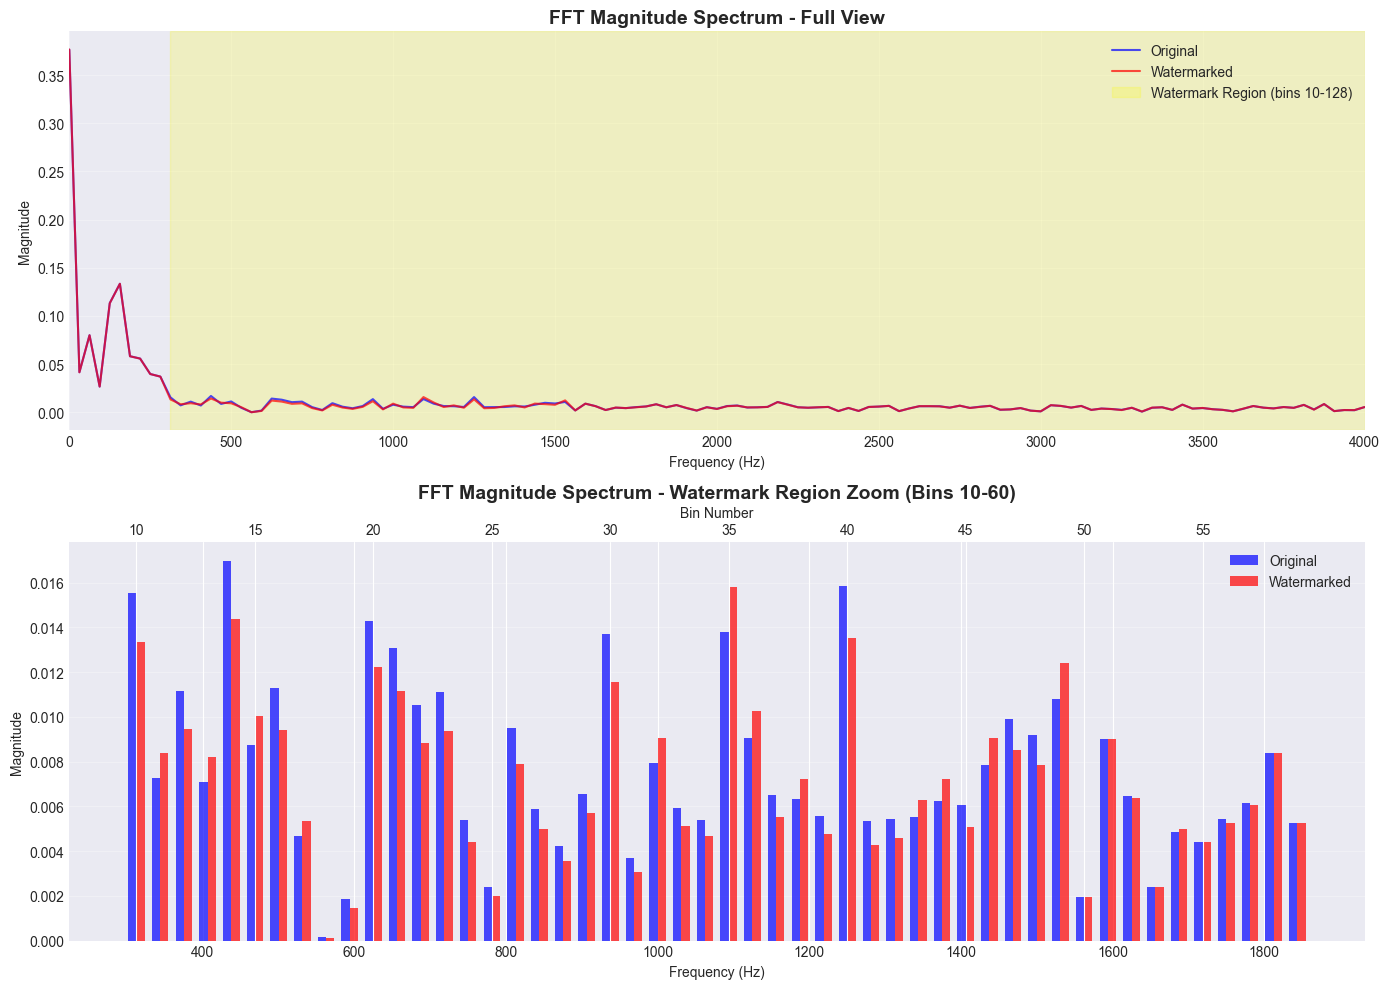


Frequency resolution: 31.25 Hz per bin
Bin 10 frequency: 312.50 Hz
Bin 128 frequency: 4000.00 Hz


In [4]:
# Extract one frame for FFT analysis
frame_len = 256  # 32ms at 8kHz
start_sample = 0  # Start of first frame

frame_orig = audio_orig_norm[start_sample:start_sample + frame_len]
frame_wm = audio_wm_norm[start_sample:start_sample + frame_len]

# Compute FFT
fft_orig = rfft(frame_orig)
fft_wm = rfft(frame_wm)

# Get magnitudes
magnitude_orig = np.abs(fft_orig)
magnitude_wm = np.abs(fft_wm)

# Frequency axis
frequencies = rfftfreq(frame_len, 1/sample_rate_orig)

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Full spectrum comparison
ax1.plot(frequencies, magnitude_orig, label='Original', alpha=0.7, linewidth=1.5, color='blue')
ax1.plot(frequencies, magnitude_wm, label='Watermarked', alpha=0.7, linewidth=1.5, color='red')
ax1.axvspan(frequencies[10], frequencies[min(128, len(frequencies)-1)], 
            alpha=0.2, color='yellow', label='Watermark Region (bins 10-128)')
ax1.set_title('FFT Magnitude Spectrum - Full View', fontsize=14, fontweight='bold')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Magnitude')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 4000)

# Zoomed view on watermark region
watermark_start_bin = 10
watermark_end_bin = min(60, len(magnitude_orig))  # Show first 50 watermark bins

bins_to_show = np.arange(watermark_start_bin, watermark_end_bin)
freq_to_show = frequencies[bins_to_show]

width = (frequencies[1] - frequencies[0]) * 0.35
ax2.bar(freq_to_show - width/2, magnitude_orig[bins_to_show], 
        width=width, label='Original', alpha=0.7, color='blue')
ax2.bar(freq_to_show + width/2, magnitude_wm[bins_to_show], 
        width=width, label='Watermarked', alpha=0.7, color='red')

ax2.set_title('FFT Magnitude Spectrum - Watermark Region Zoom (Bins 10-60)', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Magnitude')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add bin numbers as secondary x-axis
ax2_top = ax2.twiny()
ax2_top.set_xlim(ax2.get_xlim())
ax2_top.set_xlabel('Bin Number')
tick_freq = freq_to_show[::5]  # Every 5th bin
tick_bins = bins_to_show[::5]
ax2_top.set_xticks(tick_freq)
ax2_top.set_xticklabels(tick_bins)

plt.tight_layout()
plt.show()

print(f"\nFrequency resolution: {frequencies[1] - frequencies[0]:.2f} Hz per bin")
print(f"Bin 10 frequency: {frequencies[10]:.2f} Hz")
print(f"Bin 128 frequency: {frequencies[min(128, len(frequencies)-1)]:.2f} Hz")


## 3. Watermark Bit Visualization
Decode and visualize the watermark bits from the first frame.

**Pilot pattern:** `[0, 1, 0, 1, 0, 1, 0, 1]`
- Bit 0: magnitude reduced by 0.85x
- Bit 1: magnitude boosted by 1.15x


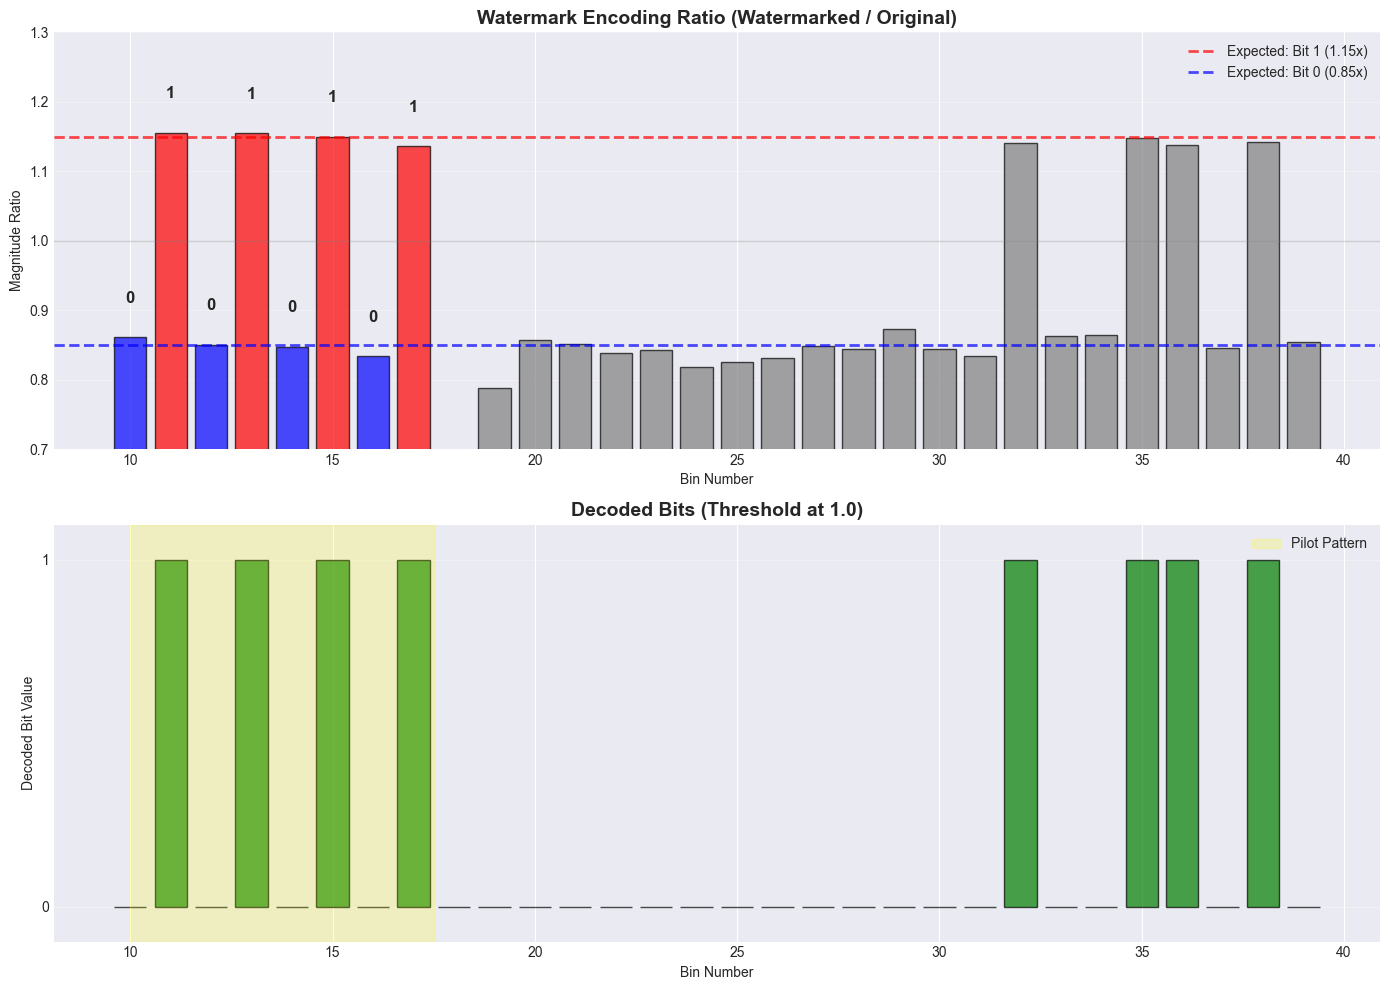


Pilot Pattern Verification:
Expected: [0, 1, 0, 1, 0, 1, 0, 1]
Decoded:  [0, 1, 0, 1, 0, 1, 0, 1]
Matches:  8/8 (100.0%)


In [5]:
# Calculate magnitude ratio (watermarked / original)
watermark_bins = 119  # Maximum bins that can hold watermark data
ratio = np.zeros(watermark_bins)

for i in range(watermark_bins):
    bin_idx = 10 + i
    if bin_idx < len(magnitude_orig) and magnitude_orig[bin_idx] > 1e-6:
        ratio[i] = magnitude_wm[bin_idx] / magnitude_orig[bin_idx]
    else:
        ratio[i] = 1.0

# Known pilot pattern
pilot_pattern = [0, 1, 0, 1, 0, 1, 0, 1]

# Plot ratio for first 30 bins (pilot + some data)
bins_to_analyze = 30
bin_numbers = np.arange(10, 10 + bins_to_analyze)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Magnitude ratio
colors = ['red' if i < 8 and pilot_pattern[i] == 1 else 'blue' if i < 8 else 'gray' 
          for i in range(bins_to_analyze)]
bars = ax1.bar(bin_numbers, ratio[:bins_to_analyze], color=colors, alpha=0.7, edgecolor='black')

# Add reference lines
ax1.axhline(y=1.15, color='red', linestyle='--', linewidth=2, label='Expected: Bit 1 (1.15x)', alpha=0.7)
ax1.axhline(y=0.85, color='blue', linestyle='--', linewidth=2, label='Expected: Bit 0 (0.85x)', alpha=0.7)
ax1.axhline(y=1.0, color='gray', linestyle='-', linewidth=1, alpha=0.3)

ax1.set_title('Watermark Encoding Ratio (Watermarked / Original)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Bin Number')
ax1.set_ylabel('Magnitude Ratio')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0.7, 1.3)

# Add pilot pattern annotation
for i in range(8):
    ax1.text(10 + i, ratio[i] + 0.05, str(pilot_pattern[i]), 
             ha='center', fontsize=12, fontweight='bold')

# Decoded bits visualization
threshold = 1.0
decoded_bits = (ratio[:bins_to_analyze] > threshold).astype(int)

ax2.bar(bin_numbers, decoded_bits, color='green', alpha=0.7, edgecolor='black')
ax2.set_title('Decoded Bits (Threshold at 1.0)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Bin Number')
ax2.set_ylabel('Decoded Bit Value')
ax2.set_ylim(-0.1, 1.1)
ax2.set_yticks([0, 1])
ax2.grid(True, alpha=0.3, axis='y')

# Highlight pilot region
ax2.axvspan(10, 17.5, alpha=0.2, color='yellow', label='Pilot Pattern')
ax2.legend()

plt.tight_layout()
plt.show()

# Verify pilot pattern
pilot_bits = decoded_bits[:8]
matches = np.sum(pilot_bits == pilot_pattern)
print(f"\nPilot Pattern Verification:")
print(f"Expected: {pilot_pattern}")
print(f"Decoded:  {pilot_bits.tolist()}")
print(f"Matches:  {matches}/8 ({matches/8*100:.1f}%)")


## 4. Spectrogram View
Visualize how the frequency content evolves over time across multiple frames.


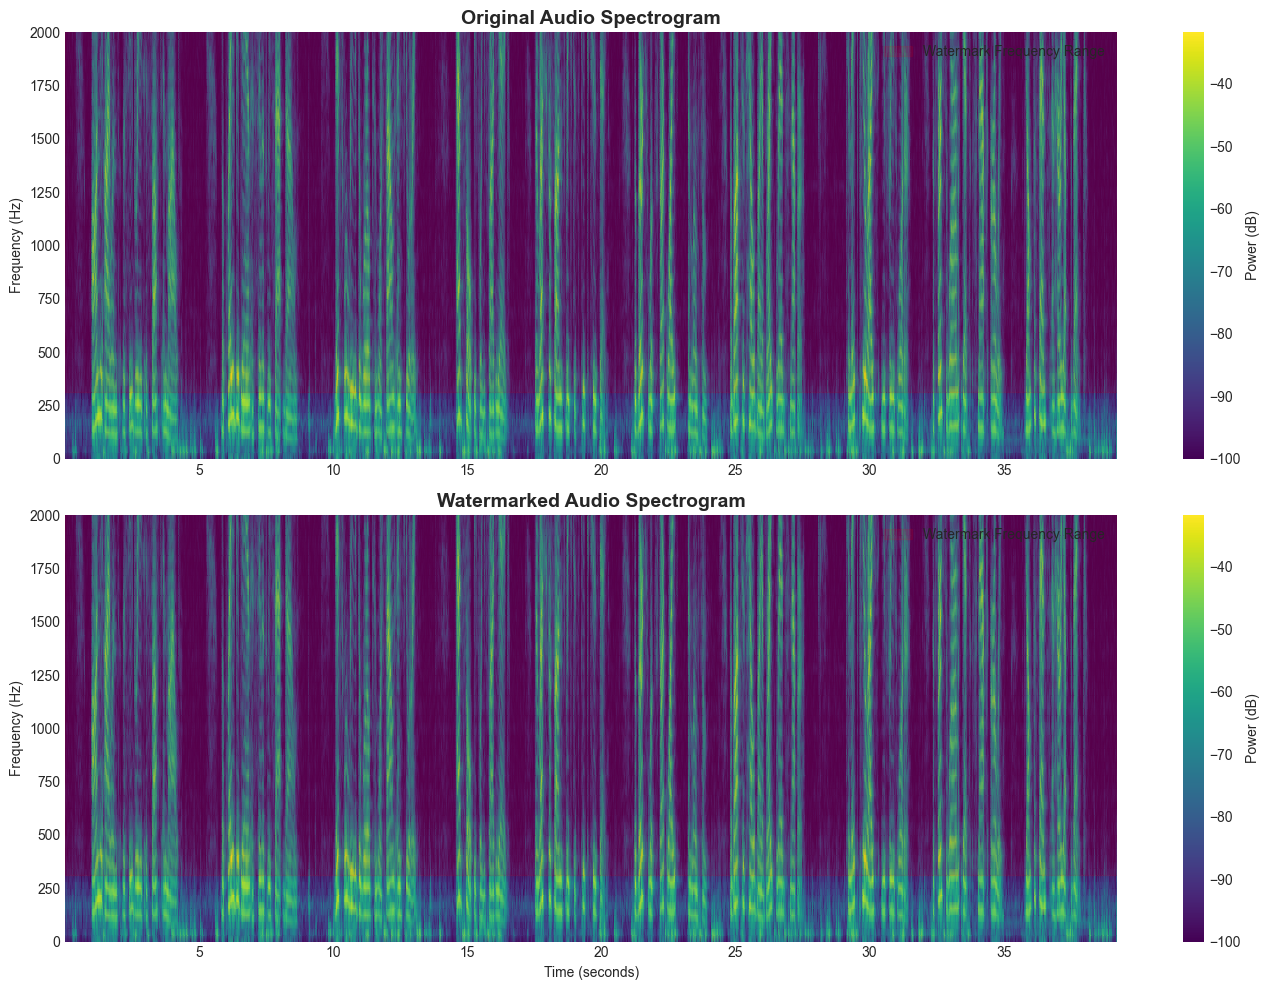

In [6]:
from scipy import signal

# Create spectrograms
f_orig, t_orig, Sxx_orig = signal.spectrogram(audio_orig_norm, sample_rate_orig, 
                                               nperseg=256, noverlap=128)
f_wm, t_wm, Sxx_wm = signal.spectrogram(audio_wm_norm, sample_rate_wm, 
                                         nperseg=256, noverlap=128)

# Plot spectrograms
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Original spectrogram
im1 = ax1.pcolormesh(t_orig, f_orig, 10 * np.log10(Sxx_orig + 1e-10), 
                     shading='gouraud', cmap='viridis')
ax1.set_title('Original Audio Spectrogram', fontsize=14, fontweight='bold')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_ylim(0, 2000)
plt.colorbar(im1, ax=ax1, label='Power (dB)')

# Highlight watermark frequency range
ax1.axhspan(312.5, 4000, alpha=0.1, color='red', label='Watermark Frequency Range')
ax1.legend(loc='upper right')

# Watermarked spectrogram
im2 = ax2.pcolormesh(t_wm, f_wm, 10 * np.log10(Sxx_wm + 1e-10), 
                     shading='gouraud', cmap='viridis')
ax2.set_title('Watermarked Audio Spectrogram', fontsize=14, fontweight='bold')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_xlabel('Time (seconds)')
ax2.set_ylim(0, 2000)
plt.colorbar(im2, ax=ax2, label='Power (dB)')

# Highlight watermark frequency range
ax2.axhspan(312.5, 4000, alpha=0.1, color='red', label='Watermark Frequency Range')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


## 5. Lab Equipment Measurement Guide

Based on the analysis above, here's what you'd measure with lab equipment:

### Frequency Bins to Measure:
- **Bin 10:** 312.5 Hz (Pilot bit 0)
- **Bin 11:** 343.75 Hz (Pilot bit 1)
- **Bin 12:** 375.0 Hz (Pilot bit 0)
- **Bin 13:** 406.25 Hz (Pilot bit 1)
- And so on...

### Using a Spectrum Analyzer:
1. Set frequency span: 300 Hz - 4000 Hz
2. Resolution bandwidth: ~20 Hz
3. Look for alternating high/low pattern in first 8 bins
4. Record relative amplitudes to decode bits

### Expected Amplitude Pattern:
- **High bins** should be ~15% stronger than neighbors
- **Low bins** should be ~15% weaker than neighbors


In [7]:
# Generate measurement table for lab work
print("=" * 70)
print("SPECTRUM ANALYZER MEASUREMENT GUIDE")
print("=" * 70)
print(f"\n{'Bin':<6} {'Frequency':<12} {'Expected':<12} {'Description':<30}")
print("-" * 70)

pilot = [0, 1, 0, 1, 0, 1, 0, 1]
for i in range(24):  # First 24 bins (pilot + length header)
    bin_num = 10 + i
    freq = bin_num * 31.25
    
    if i < 8:
        expected = "LOW" if pilot[i] == 0 else "HIGH"
        desc = f"Pilot bit {i} = {pilot[i]}"
    elif i < 24:
        expected = "MEASURE"
        desc = f"Length header bit {i-8}"
    else:
        expected = "MEASURE"
        desc = "Message data"
    
    print(f"{bin_num:<6} {freq:<12.2f} {expected:<12} {desc:<30}")

print("\n" + "=" * 70)
print("Note: HIGH means magnitude ~1.15x, LOW means magnitude ~0.85x")
print("Compare each bin to its neighbors to determine relative amplitude.")
print("=" * 70)


SPECTRUM ANALYZER MEASUREMENT GUIDE

Bin    Frequency    Expected     Description                   
----------------------------------------------------------------------
10     312.50       LOW          Pilot bit 0 = 0               
11     343.75       HIGH         Pilot bit 1 = 1               
12     375.00       LOW          Pilot bit 2 = 0               
13     406.25       HIGH         Pilot bit 3 = 1               
14     437.50       LOW          Pilot bit 4 = 0               
15     468.75       HIGH         Pilot bit 5 = 1               
16     500.00       LOW          Pilot bit 6 = 0               
17     531.25       HIGH         Pilot bit 7 = 1               
18     562.50       MEASURE      Length header bit 0           
19     593.75       MEASURE      Length header bit 1           
20     625.00       MEASURE      Length header bit 2           
21     656.25       MEASURE      Length header bit 3           
22     687.50       MEASURE      Length header bit 4        